In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sn
import pandas as pd

from scipy import signal
import pywt

import os
import time
import datetime
import random
import h5py
import pickle
import copy

from ggs import *

import cv2 as cv

from tensorflow.keras import models
from sklearn.preprocessing import LabelEncoder

from platform import python_version
print(python_version())
import warnings
warnings.simplefilter("ignore")

3.8.8


# Read and Prepare Data

In [2]:
def readData(accDir, annotFile):
    files = os.listdir(accDir)
    files_csv = [f for f in files if f[-3:] == 'csv']
    empatica_dict = dict()
    for f in files_csv:
        data = np.genfromtxt(accDir+f, delimiter=',') # creates numpy array for each Empatica acc csv file
        key = int(float(f.strip("ACC.csv")))
        empatica_dict[key] = data
    tmp = pd.read_excel(annotFile, sheet_name=None)
    annot_dict = dict(zip(tmp.keys(), [i.dropna() for i in tmp.values()])) # Remove the rows with NaN values (some with ladder 2 missing)
    return empatica_dict, annot_dict

def getLabeledDict(empatica_dict, annot_dict, subject_ids, SR):
    labeled_dict = {}; taskInd_dict = {}
    for id in subject_ids:
        start_time = int(empatica_dict[id][0,0])
        acc = empatica_dict[id][2:,:]
        label = list(map(lambda i: i.replace("_end", "").replace("_start", ""), annot_dict['P'+ str(id)].taskName.tolist()))
        task_time= list(map(lambda i: time.mktime(datetime.datetime.strptime(i[:6] + '20' + i[6:], "%m/%d/%Y %H:%M:%S").timetuple()),
                            annot_dict['P'+ str(id)].startTime_global.tolist()))
        task_ind = [int(x - start_time)*SR for x in task_time]
        taskInd_dict[id] = task_ind
        label_tmp = np.empty(acc.shape[0], dtype=object)
        for i, (j, k) in enumerate(zip(task_ind[0::2], task_ind[1::2])):
            tmpInd = 2*i
            label_tmp[j:k] = label[tmpInd]
        acc_mag = np.sqrt(np.sum(acc**2, axis=1))[:,None]
        accel = np.hstack((acc, acc_mag))
        labeled_dict[id] = pd.DataFrame(np.hstack((accel, label_tmp.reshape(label_tmp.shape[0],1))), columns=['X', 'Y', 'Z', 'Mag', 'label'])
    return labeled_dict, taskInd_dict

In [3]:
sepAccDict, sepAnnotDict = readData(accDir='./Data/Acc Data/', annotFile='./Data/Annotation Data/separate.xlsx')
SR=int(sepAccDict[8][1,0])

sepSubIDs = list(range(8,45))
# sepSubIDs.remove(27) # does not have lift
sepLabeledDict_, sepTaskIndDict = getLabeledDict(sepAccDict, sepAnnotDict, sepSubIDs, SR)

## Apply Low Pass Filter

In [4]:
# Apply Filter on All Subjects
n=4; fc=2; w=fc/(SR/2)
b, a = signal.butter(n, w, 'low')
sepLabeledDict_filtered = dict(map(lambda key: (key, signal.filtfilt(b, a, x=sepLabeledDict_[key].drop(columns='label'), axis=0)), sepLabeledDict_.keys()))
# back to DF and add label
sepLabeledDict_filtered_dfs = dict(map(lambda key: (
                                                        key, pd.DataFrame(sepLabeledDict_filtered[key],columns=['X', 'Y', 'Z', 'Mag']).assign(label=sepLabeledDict_[key].label)
                                                    ), sepLabeledDict_filtered.keys()))
# Remove data without label
filt_noNA_dict = dict(map(lambda key: (key, sepLabeledDict_filtered_dfs[key].dropna()), sepLabeledDict_filtered_dfs.keys()))

## Load and Correct GGS Segments

In [5]:
segments = pd.read_pickle('trained_model/GGS_segments.pickle')
new_seg_dict = {}
for sub in segments.keys():
    segment = segments[sub]
    seg = segment[-1]
    new_segment = []
    
    thresh = 960 # ensure 30 seconds between segments
    idx = np.where(np.diff(seg) < thresh)[0]
    cluster_idxs_ = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
    clusters_idxs = [np.append(elem, max(elem) + 1) for elem in cluster_idxs_]
    cluster_vals = [np.array(seg)[idxs] for idxs in clusters_idxs]

    new_segs = list(set(seg) - set(np.concatenate(cluster_vals)))
    for elem in cluster_vals:
        if any(elem==0):
            new_segs.append(0)
        elif any(elem==seg[-1]):
            new_segs.append(seg[-1])
        else:
            for early_seg in segment:
                if any((np.array(early_seg)>(min(elem) - 30)) & (np.array(early_seg)<(max(elem) + 30))):
                    replacement = min(np.array(early_seg)[(np.array(early_seg)>(min(elem) - 30)) & (np.array(early_seg)<(max(elem) + 30))])
                    new_segs.append(replacement)
                    break
    new_seg_dict[sub] = sorted(new_segs)

# Test the Pipeline on Subjects: 8, 9, 10, 11

**Steps:**

> 1- Extract windows of `10 seconds` within each segment

> 2- Perform continuous wavelet transform (`CWT`) in each window (extract features)

> 3- Classify each window using the trained `CNN` model

> 4- Classify each segment by `voting`

> 5- Modify the segments by `merging neighboring windows` of same class

> 6- `Count` the repititions in lifting and walking windows

# Load the trained model

In [6]:
model = models.load_model('trained_model/tf_model/')
test_subs = pd.read_pickle('trained_model/test_subs.pickle')
history = pd.read_pickle('trained_model/keras_history.pickle')
scaler = pd.read_pickle('trained_model/scaler.pickle')
labels_categorical = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder', 'electricPanel', 'overhead']
labels_encoded = LabelEncoder().fit_transform(labels_categorical).tolist()
labels_dict = dict([(numeric_, categorical_) for numeric_, categorical_ in zip(labels_encoded, labels_categorical)])

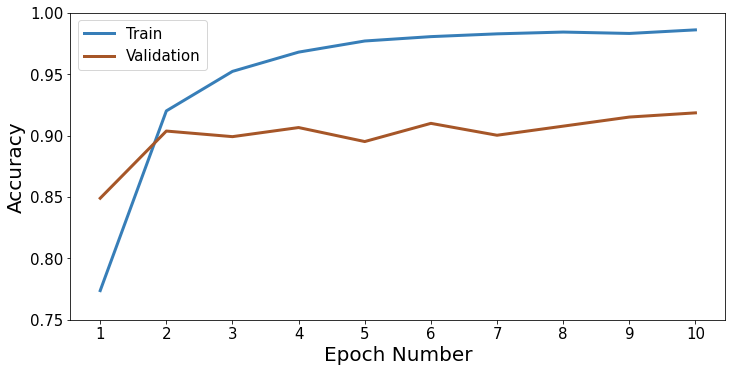

In [7]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(range(1, 11), history['accuracy'], c=CB_color_cycle[0], label='Train', linewidth=3)
ax.plot(range(1, 11), history['val_accuracy'], c=CB_color_cycle[4], label='Validation', linewidth=3)
ax.set_ylim([0.75, 1])
ax.set_xlabel('Epoch Number', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)
ax.set_xticks(range(1, 11))
ax.tick_params(labelsize=15)
# ax.plot(history['loss'], c=CB_color_cycle[0], label='Train')
# ax.plot(history['val_loss'], c=CB_color_cycle[4], label='Validation')

ax.legend(fontsize=15)
f.tight_layout(pad=0.1)
f.savefig('./outputs/CNN classification/accuracy.png')
plt.show()

## Automated 

In [8]:
cwt_dict = {}
for sub in sorted(test_subs):
    tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder1', 'ladder2', 'electricPanel', 'overhead']
    sig_ = filt_noNA_dict[sub]
    sig = sig_[sig_.label.isin(tasks)]
    sig.label.replace({'ladder1':'ladder', 'ladder2':'ladder'}, inplace=True)

    winLen = 320
    scales = range(1,200)
    waveletname = 'morl'
    cwt_dict[sub] = {}
    for label, label_df in sig.groupby(by='label'):
        cwt_dict[sub][label] = np.zeros((label_df.shape[0]//winLen, max(scales), winLen, 3))
        j = 0
        for window, window_df in label_df.groupby(by=np.arange(label_df.shape[0])//winLen):
            if window_df.shape[0] == winLen:
                ########### cwt transform
                for i in range(3):
                    tmp_sig = window_df.values[:,i]
                    coeff, freq = pywt.cwt(tmp_sig, scales, waveletname, 1/SR)
                    cwt_dict[sub][label][j, :,:,i] = coeff
                j += 1

In [9]:
def CountReps(axis, new_segs, sig, wavename, wave_coeff_perc, scale_interv, area_thresh_coeff, num_contours, SR, scales):
    sig_label = sig[axis].values[new_segs[idx]:new_segs[idx + 1]]
    [coefficients, frequencies] = pywt.cwt(sig_label, scales, wavename, sampling_period=1/SR)
    thresh = np.percentile(abs(coefficients), wave_coeff_perc)
    ret, thresh_img__ = cv.threshold(abs(coefficients), thresh, 255, cv.THRESH_BINARY)
    thresh_img_ = thresh_img__.astype('uint8')
    thresh_img = thresh_img_[scale_interv,:]
    contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    area = [cv.contourArea(cnt) for cnt in contours]
    area_thresh = np.percentile(area, 90)*area_thresh_coeff
    contours_np = np.array(contours)
    area_np = np.array(area)
    large_contours = contours_np[np.where(area_np>area_thresh)]
    return int(round(large_contours.shape[0]/num_contours, 0))

In [10]:
# new_segs_dict = {}
# new_labels_dict = {}
# act_count_dict = {}
# for sub in sorted(test_subs):
#     segs = new_seg_dict[sub]
#     # tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'ladder1']
#     tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder1', 'ladder2', 'electricPanel', 'overhead']
#     sig_ = filt_noNA_dict[sub]
#     sig = sig_[sig_.label.isin(tasks)]

#     winLen = 320
#     scales = range(1,200)
#     waveletname = 'morl'
#     cwt_dict = {}
#     for i in range(len(segs)-1):
#         ########### create window of length 320
#         signal_seg = sig.iloc[segs[i]:segs[i+1],:3]
#         window_list = []
#         for g, df in signal_seg.groupby(np.arange(signal_seg.shape[0]) // winLen):
#             if df.shape[0]==winLen:
#                 window_list.append(df.values)
#         window_np = np.array(window_list)
#         ########### cwt transform
#         cwt_dict[i] = np.zeros(shape=(window_np.shape[0], max(scales), winLen, 3), dtype=np.float)
#         for j in range(window_np.shape[0]):
#             for k in range(window_np.shape[2]):
#                 tmp_sig = window_np[j,:,k]
#                 coeff, freq = pywt.cwt(tmp_sig, scales, waveletname, 1/SR)
#                 cwt_dict[i][j, :, :, k] = coeff

#     ############## predict labels within each segment using the trained model and voting
#     scaler = max([np.max(elem) for elem in cwt_dict.values()])
#     pred_label = dict()
#     for key in cwt_dict.keys():
#         OH_pred = model.predict(cwt_dict[key]/scaler)
#         numeric_pred = np.argmax(OH_pred, axis=1)
#         most_frequent = np.bincount(numeric_pred).argmax()
#         pred_label[key] = labels_dict[most_frequent]

#     ############## remove segmenets for same neighbouring labels
#     labels = list(pred_label.values())
#     new_segs = [segs[0], segs[-1]]
#     new_labels = [labels[0]]
#     for i in range(len(labels[:-1])):
#         if labels[i] != labels[i+1]:
#             new_segs.append(segs[i+1])
#             new_labels.append(labels[i+1])
#     new_segs = sorted(new_segs)
#     new_segs_dict[sub] = new_segs
#     new_labels_dict[sub] = np.array(new_labels)
    
#     ############## Count number of Repetitions in `Walkin` and `Lifting`
#     count_dict = {}
#     labels = ['walk', 'lift', 'hoist']
#     for label in labels:
#         count_dict[label] = []
#         Idxs = []
#         Idxs.extend(list(np.where(np.array(new_labels)==label)[0]))
#         for idx in Idxs:
#             if label=='walk':
#                 seg_reps = CountReps(axis='Y', new_segs=new_segs, sig=sig, wavename='morl', wave_coeff_perc=70,
#                                      scale_interv=slice(20, 35), area_thresh_coeff=0.3, num_contours=2, SR=SR, scales=scales)
#             elif label=='lift':
#                 seg_reps = CountReps(axis='Y', new_segs=new_segs, sig=sig, wavename='morl', wave_coeff_perc=80,
#                                      scale_interv=slice(90, None), area_thresh_coeff=0.3, num_contours=4, SR=SR, scales=scales)
#             elif label=='hoist':
#                 seg_reps = CountReps(axis='Y', new_segs=new_segs, sig=sig, wavename='gaus1', wave_coeff_perc=40,
#                                      scale_interv=slice(None, 30), area_thresh_coeff=0.1, num_contours=2, SR=SR, scales=scales)
#             count_dict[label].append(seg_reps)
#             act_count_dict[sub] = count_dict

In [11]:
new_segs_dict = {}
new_labels_dict = {}
act_duration_count_dict = {}
for sub in sorted(test_subs):
    segs = new_seg_dict[sub]
    # tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'ladder1']
    tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder1', 'ladder2', 'electricPanel', 'overhead']
    sig_ = filt_noNA_dict[sub]
    sig = sig_[sig_.label.isin(tasks)]

    winLen = 320
    scales = range(1,200)
    waveletname = 'morl'
    cwt_dict = {}
    for i in range(len(segs)-1):
        ########### create window of length 320
        signal_seg = sig.iloc[segs[i]:segs[i+1],:3]
        window_list = []
        for g, df in signal_seg.groupby(np.arange(signal_seg.shape[0]) // winLen):
            if df.shape[0]==winLen:
                window_list.append(df.values)
        window_np = np.array(window_list)
        ########### cwt transform
        cwt_dict[i] = np.zeros(shape=(window_np.shape[0], max(scales), winLen, 3), dtype=np.float)
        for j in range(window_np.shape[0]):
            for k in range(window_np.shape[2]):
                tmp_sig = window_np[j,:,k]
                coeff, freq = pywt.cwt(tmp_sig, scales, waveletname, 1/SR)
                cwt_dict[i][j, :, :, k] = coeff

    ############## predict labels within each segment using the trained model and voting
    scaler = max([np.max(elem) for elem in cwt_dict.values()])
    pred_label = dict()
    for key in cwt_dict.keys():
        OH_pred = model.predict(cwt_dict[key]/scaler)
        numeric_pred = np.argmax(OH_pred, axis=1)
        most_frequent = np.bincount(numeric_pred).argmax()
        pred_label[key] = labels_dict[most_frequent]

    ############## remove segmenets for same neighbouring labels
    labels = list(pred_label.values())
    new_segs = [segs[0], segs[-1]]
    new_labels = [labels[0]]
    for i in range(len(labels[:-1])):
        if labels[i] != labels[i+1]:
            new_segs.append(segs[i+1])
            new_labels.append(labels[i+1])
    new_segs = sorted(new_segs)
    new_segs_dict[sub] = new_segs
    new_labels_dict[sub] = np.array(new_labels)
    
    ############## Duration / number of Repetitions
    duration_count_dict = {}
    labels = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder', 'electricPanel', 'overhead']
    for label in labels:
        duration_count_dict[label] = []
        Idxs = []
        Idxs.extend(list(np.where(np.array(new_labels)==label)[0]))
        for idx in Idxs:
            if label not in ['lift', 'hoist']:
                seg_duration_count = (new_segs[idx + 1] - new_segs[idx])//SR
            elif label=='lift':
                seg_duration_count = CountReps(axis='Y', new_segs=new_segs, sig=sig, wavename='morl', wave_coeff_perc=80,
                                               scale_interv=slice(90, None), area_thresh_coeff=0.3, num_contours=4, SR=SR, scales=scales)
            elif label=='hoist':
                seg_duration_count = CountReps(axis='Y', new_segs=new_segs, sig=sig, wavename='gaus1', wave_coeff_perc=40,
                                               scale_interv=slice(None, 30), area_thresh_coeff=0.1, num_contours=2, SR=SR, scales=scales)
            duration_count_dict[label].append(seg_duration_count)
    act_duration_count_dict[sub] = duration_count_dict

## Plot with Modified Segments, Predicted Labels, and Counts for Test Subjects

In [31]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
subs = sorted(test_subs)
sub_tab=[widgets.Output() for i in range(len(subs))]
tab = widgets.Tab(sub_tab)
for i, sub in enumerate(subs):
    tab.set_title(i,str(sub))
    sig_ = filt_noNA_dict[sub]
    sig = sig_[sig_.label.isin(tasks)]
    with sub_tab[i]:
        f, ax = plt.subplots(1, figsize=(20,5))
        ax.plot(sig.values[:,0], c=CB_color_cycle[0], label='X')
        ax.plot(sig.values[:,1], c=CB_color_cycle[4], label='Y')
        ax.plot(sig.values[:,2], c=CB_color_cycle[8], label='Z')
        for v in new_segs_dict[sub]:
            ax.axvline(v, c='k', linestyle = '--')
        ax.set_ylim([-150, 110])
        x_locs = (np.array(new_segs_dict[sub][:-1]) + np.array(new_segs_dict[sub][1:])) // 2
        y_locs = ([130, 165] * 10)[:new_labels_dict[sub].shape[0]]
        
        tmp_count_duration = copy.deepcopy(act_duration_count_dict[sub])
        for x_loc, y_loc, label in zip(x_locs, y_locs, new_labels_dict[sub]):
            count_duration_str = str(tmp_count_duration[label][0])
            tmp_count_duration[label] = np.delete(tmp_count_duration[label], 0)
            if label == 'electricPanel':
                label = 'EP'
            elif label == 'overhead':
                label = 'OH'
            ax.text(x_loc-1500, y_loc, label, fontsize=20)
            if label in ['lift', 'hoist']:
                ax.text(x_loc-1700, y_loc-17, '(' + count_duration_str + ' R)', fontsize=15)
            else:
                ax.text(x_loc-1700, y_loc-17, '(' + count_duration_str + ' S)', fontsize=15)
        ax.legend()
        plt.show()
display(tab)

In [11]:
# CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
# subs = sorted(test_subs)
# sub_tab=[widgets.Output() for i in range(len(subs))]
# tab = widgets.Tab(sub_tab)
# for i, sub in enumerate(subs):
#     tab.set_title(i,str(sub))
#     sig_ = filt_noNA_dict[sub]
#     sig = sig_[sig_.label.isin(tasks)]
#     parint_labels = [label.replace('electricPanel', 'EP').replace('overhead', 'OH') for label in new_labels_dict[sub]]
#     with sub_tab[i]:
#         f, ax = plt.subplots(1, figsize=(20,5))
#         ax.plot(sig.values[:,0], c=CB_color_cycle[0], label='X')
#         ax.plot(sig.values[:,1], c=CB_color_cycle[4], label='Y')
#         ax.plot(sig.values[:,2], c=CB_color_cycle[8], label='Z')
#         for v in new_segs_dict[sub]:
#             ax.axvline(v, c='k', linestyle = '--')
#         ax.set_ylim([-150, 110])
#         x_locs = (np.array(new_segs_dict[sub][:-1]) + np.array(new_segs_dict[sub][1:])) // 2
#         y_locs = ([130, 150] * 10)[:new_labels_dict[sub].shape[0]]
#         walk_idx = 0
#         lift_idx = 0
#         hoist_idx = 0
#         for x_loc, y_loc, label in zip(x_locs, y_locs, parint_labels):
#             ax.text(x_loc-1500, y_loc, label, fontsize=20)
#             if label=='walk':
#                 ax.text(x_loc-1500, y_loc-15, '(' + str(act_count_dict[sub]['walk'][walk_idx]) + ')', fontsize=15)
#                 walk_idx += 1
#             if label=='lift':
#                 ax.text(x_loc-1500, y_loc-15, '(' + str(act_count_dict[sub]['lift'][lift_idx]) + ')', fontsize=15)
#                 lift_idx += 1
#             if label=='hoist':
#                 ax.text(x_loc-1500, y_loc-15, '(' + str(act_count_dict[sub]['hoist'][hoist_idx]) + ')', fontsize=15)
#                 hoist_idx += 1
#         ax.legend()
#         plt.show()
# display(tab)

# Export Figure for Wole Framework

In [49]:
tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder1', 'ladder2', 'electricPanel', 'overhead']
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
for sub in test_subs:
    sig_ = filt_noNA_dict[sub]
    sig = sig_[sig_.label.isin(tasks)]

    f, ax = plt.subplots(1, figsize=(20,4))
    ax.plot(sig.values[:,0]*9.81/64, c=CB_color_cycle[0], label='$a_X$')
    ax.plot(sig.values[:,1]*9.81/64, c=CB_color_cycle[4], label='$a_Y$')
    ax.plot(sig.values[:,2]*9.81/64, c=CB_color_cycle[8], label='$a_Z$')
    for v in new_segs_dict[sub]:
        ax.axvline(v, c='k', linestyle = '--')
    ax.set_ylim([-23, 17])
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(loc='lower left', fontsize=22)
    # ax.set_title('Test Subject 1', fontsize=17)
    ax.set_xticklabels([])
    ax.set_ylabel('Acceleration ($m/s^2$)', fontsize=22)

    x_locs = (np.array(new_segs_dict[sub][:-1]) + np.array(new_segs_dict[sub][1:])) // 2
    y_locs = ([20.5, 23] * 10)[:new_labels_dict[sub].shape[0]]
    tmp_count_duration = copy.deepcopy(act_duration_count_dict[sub])
    for x_loc, y_loc, label in zip(x_locs, y_locs, new_labels_dict[sub]):
        count_duration_str = str(tmp_count_duration[label][0])
        tmp_count_duration[label] = np.delete(tmp_count_duration[label], 0)
        if label == 'electricPanel':
            label = 'EP'
        elif label == 'overhead':
            label = 'OH'
        ax.text(x_loc-1500, y_loc, label, fontsize=20)
        if label in ['lift', 'hoist']:
            ax.text(x_loc-1700, y_loc-2.8, '(' + count_duration_str + ' R)', fontsize=15)
        else:
            ax.text(x_loc-1700, y_loc-2.8, '(' + count_duration_str + ' S)', fontsize=15)
    f.tight_layout(pad=0)#.1)
    f.savefig('./outputs/framework/framework' + str(sub) + '.png', bbox_inches="tight")
#     plt.show()
    plt.close()

In [109]:
# # sub = 8
# for sub in test_subs:
#     CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
#     tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder1', 'ladder2', 'electricPanel', 'overhead']
#     sig_ = filt_noNA_dict[sub]
#     sig = sig_[sig_.label.isin(tasks)]
#     parint_labels = [label.replace('electricPanel', 'EP').replace('overhead', 'OH') for label in new_labels_dict[sub]]

#     f, ax = plt.subplots(1, figsize=(20,3.5))
#     ax.plot(sig.values[:,0]*9.81/64, c=CB_color_cycle[0], label='$a_X$')
#     ax.plot(sig.values[:,1]*9.81/64, c=CB_color_cycle[4], label='$a_Y$')
#     ax.plot(sig.values[:,2]*9.81/64, c=CB_color_cycle[8], label='$a_Z$')
#     for v in new_segs_dict[sub]:
#         ax.axvline(v, c='k', linestyle = '--')
#     ax.set_ylim([-23, 17])
#     ax.tick_params(axis='both', labelsize=15)
#     ax.legend(loc='lower left', fontsize=22)
#     # ax.set_title('Test Subject 1', fontsize=17)
#     ax.set_xticklabels([])
#     ax.set_ylabel('Acceleration ($m/s^2$)', fontsize=22)

#     x_locs = (np.array(new_segs_dict[sub][:-1]) + np.array(new_segs_dict[sub][1:])) // 2
#     y_locs = ([20.5, 22] * 10)[:new_labels_dict[sub].shape[0]]
#     walk_idx = 0
#     lift_idx = 0
#     hoist_idx = 0
#     for x_loc, y_loc, label in zip(x_locs, y_locs, parint_labels):
#         ax.text(x_loc-1500, y_loc, label, fontsize=20)
#     #     if label=='walk':
#     #         ax.text(x_loc-1500, y_loc-2.3, '(' + str(act_count_dict[sub]['walk'][walk_idx]) + ')', fontsize=15)
#     #         walk_idx += 1
#         if label=='lift':
#             ax.text(x_loc-1500, y_loc-2.5, '(' + str(act_count_dict[sub]['lift'][lift_idx]) + ')', fontsize=15)
#             lift_idx += 1
#         if label=='hoist':
#             ax.text(x_loc-1000, y_loc-2.5, '(' + str(act_count_dict[sub]['hoist'][hoist_idx]) + ')', fontsize=15)
#             hoist_idx += 1

#     f.tight_layout(pad=0)#.1)
#     f.savefig('./outputs/framework/framework' + str(sub) + '.png', bbox_inches="tight")
# #     plt.show()
#     plt.close()

# Export Figure for Segmentation

In [ ]:
# seg_sub_list = 8
for sub in test_subs:
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder1', 'ladder2', 'electricPanel', 'overhead']
    sig_ = filt_noNA_dict[sub]
    sig = sig_[sig_.label.isin(tasks)]
    sig.label.replace({'ladder1':'ladder', 'ladder2':'ladder'}, inplace=True)

    tmp = sig.ne(sig.shift()).label.values
    true_segs = list(np.where(tmp)[0])
    true_segs.append(sig.shape[0])

    f, ax = plt.subplots(1, figsize=(20,3.5))
    ax.plot(sig.values[:,0]*9.81/64, c=CB_color_cycle[0])#, label='$a_X$')
    ax.plot(sig.values[:,1]*9.81/64, c=CB_color_cycle[4])#, label='$a_Y$')
    ax.plot(sig.values[:,2]*9.81/64, c=CB_color_cycle[8])#, label='$a_Z$')
    for v in new_segs_dict[sub]:
        ax.axvline(v, c='b', linewidth=2.5)#, marker='|', label='predicted')
    ax.axvline(c='b', linewidth=2.5, label='predicted')
    for v in true_segs:
        ax.axvline(v, c='red', linewidth=2.5, linestyle = '--')#, label='true')
    ax.axvline(c='red', linewidth=2.5, linestyle = '--', label='true')
    ax.set_ylim([-23, 17])
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(loc='lower left', fontsize=22)
    # ax.set_title('Test Subject 1', fontsize=17)
    ax.set_xticklabels([])
    ax.set_ylabel('Acceleration ($m/s^2$)', fontsize=22)


    f.tight_layout(pad=0)#.1)
    f.savefig('./outputs/segmentation/segments' + str(sub) + '.png', bbox_inches="tight")
#     plt.show()
    plt.close()

# Covering Metric

In [ ]:
covering_metric = {}
for sub in sorted(test_subs):
    sig_ = filt_noNA_dict[sub]
    sig = sig_[sig_.label.isin(tasks)]
    sig.loc[sig.label.isin(['ladder1', 'ladder2']), 'label'] = 'ladder'

    tmp = sig.ne(sig.shift()).label.values
    true_segs = list(np.where(tmp)[0])
    true_segs.append(sig.shape[0])

    truth = [list(range(st, ed)) for st, ed in zip(true_segs[:-1], true_segs[1:])]
    pred = [list(range(st, ed)) for st, ed in zip(new_segs_dict[sub][:-1], new_segs_dict[sub][1:])]
    
    summation = 0
    for t in truth:
        jaccard = []
        for p in pred:
            intersect = list(set(t) & set(p))
            union = list(set(t+p))
            jaccard.append(len(intersect)/len(union))
        summation += len(t) * max(jaccard)
    covering_metric[sub] = summation/sig.shape[0]

In [ ]:
covering_metric

In [ ]:
# true_walk_count = [164, 157, 168, 174, 150, 189, 160, 185]
# true_lift_count = [20, 20, 20, 20, 20, 20, 20, 20]

In [ ]:
cols = ['Test Subjects', 'Subject Classification Accuracy', 'Segment Classification Accuracy after Voting', 'Segmentation Covering Metric', 'Walking Counting Error', 'Lifting Counting Error']
df = pd.DataFrame(index=sorted(test_subs), columns=cols)
df['Test Subjects'] = sorted(test_subs)
df['Subject Classification Accuracy'] = [0.96, 0.95, 0.73, 0.99, 0.99, 0.97, 0.88, 0.96]
df['Segment Classification Accuracy after Voting'] = [1, 1, 0.9, 1, 1, 1, 0.9, 1]
df['Segmentation Covering Metric'] = covering_metric.values()
df['Walking Counting Error'] = [0.02, 0.06, 0.00, 0.06, 0.01, 0.07, 0.23, 0.03]
df['Lifting Counting Error'] = [0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05]
df.round(decimals=2)
# df.round(decimals=2).to_csv('./outputs/evaluation.csv')

In [ ]:
# sub = 8
# segs = new_seg_dict[sub]
# # tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'ladder1']
# tasks = ['sit', 'stand', 'walk', 'hoist', 'lift', 'push', 'type', 'ladder1', 'ladder2', 'electricPanel', 'overhead']
# sig_ = filt_noNA_dict[sub]
# sig = sig_[sig_.label.isin(tasks)]

# winLen = 320
# scales = range(1,winLen)
# waveletname = 'morl'
# cwt_dict = {}
# for i in range(len(segs)-1):
#     ########### create window of length 320
#     signal_seg = sig.iloc[segs[i]:segs[i+1],:3]
#     window_list = []
#     for g, df in signal_seg.groupby(np.arange(signal_seg.shape[0]) // winLen):
#         if df.shape[0]==winLen:
#             window_list.append(df.values)
#     window_np = np.array(window_list)
#     ########### cwt transform
#     cwt_dict[i] = np.zeros(shape=(window_np.shape[0], winLen-1, winLen-1, 3), dtype=np.float)
#     for j in range(window_np.shape[0]):
#         for k in range(window_np.shape[2]):
#             tmp_sig = window_np[j,:,k]
#             coeff, freq = pywt.cwt(tmp_sig, scales, waveletname, 1/SR)
#             cwt_dict[i][j, :, :, k] = coeff[:, :-1]
            
# ############## predict labels within each segment using the trained model and voting
# scaler = max([np.max(elem) for elem in cwt_dict.values()])
# pred_label = dict()
# for key in cwt_dict.keys():
#     OH_pred = model.predict(cwt_dict[key]/scaler)
#     numeric_pred = np.argmax(OH_pred, axis=1)
#     most_frequent = np.bincount(numeric_pred).argmax()
#     pred_label[key] = labels_dict[most_frequent]

# ############## remove segmenets for same neighbouring labels
# labels = list(pred_label.values())
# new_segs = [segs[0], segs[-1]]
# new_labels = [labels[0]]
# for i in range(len(labels[:-1])):
#     if labels[i] != labels[i+1]:
#         new_segs.append(segs[i+1])
#         new_labels.append(labels[i+1])
# new_segs = sorted(new_segs)
# new_labels = np.array(new_labels)

# ############## Count number of Repetitions in `Walkin` and `Lifting`
# count_dict = {}
# labels = ['walk', 'lift']
# for label in labels:
#     count_dict[label] = []
#     Idxs = []
#     Idxs.append(np.where(new_labels==label)[0][0])
#     for idx in Idxs:
#         sig_label = sig.Y.values[new_segs[idx]:new_segs[idx + 1]]
#         scales = np.arange(1, 200)
#         [coefficients, frequencies] = pywt.cwt(sig_label, scales, 'morl', sampling_period=1/SR)
#         power = (abs(coefficients)) ** 2
#         power_20perc = np.percentile(power, 80)
#         ret, thresh_img__ = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
#         thresh_img_ = thresh_img__.astype('uint8')
#         if label=='walk':
#             thresh_img = thresh_img_[20:35,:]
#         elif label=='lift':
#             thresh_img = thresh_img_[90:,:]

#         contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#         area = [cv.contourArea(cnt) for cnt in contours]
#         area_thresh = np.percentile(area, 90)*0.3
#         contours_np = np.array(contours)
#         area_np = np.array(area)
#         large_contours = contours_np[np.where(area_np>area_thresh)]
#         if label=='walk':
#             count_dict[label].append(int(round(large_contours.shape[0]/2, 0)))
#         elif label=='lift':
#             count_dict[label].append(int(round(large_contours.shape[0]/4, 0)))